In [1]:
from IPython.display import Image

# 7. 다양한 모델을 결합한 앙상블 학습

# 7.1 앙상블 학습
* 여러 분류기를 하나의 메타 분류기로 연결하여 개별 분류기보다 더 좋은 일반화 성능을 달성하는 것.


In [2]:
# 앙상블 학습 - 과반수 투표
Image(url='https://git.io/JtskW', width=500) 

In [3]:
Image(url='https://git.io/Jtskl', width=500) 

과반수 투표나 다수결 투표로 클래스 레이블을 예측하려면 개별 분류기 $C_j$의 예측 레이블을 모아 가장 많은 표를 받은 레이블 $\hat{y}$를 선택한다.

* 앙상블 오차 확률 = 이항 분포의 확률 질량 함수

    $P(y \ge k) = \sum_k^n{n \choose k}\epsilon^k(1-\epsilon)^{n-k}$

${n \choose k}$는 이항 계수로 n개의 원소에서 k개를 뽑는 조합의 가짓수.

In [4]:
# 확률 질량 함수 구현
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error ** k * (1-error) ** (n_classifier-k) for k in range(k_start, n_classifier+1)]
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25) # 에러율 0.25인 분류기 11개로 구성된 앙상블의 에러율

0.03432750701904297

scipy의 `binom.cdf()`를 사용하여 계산할 수도 있습니다. 성공 확률이 75%인 이항 분포에서 11번의 시도 중에 5개 이하로 성공할 누적 확률은 다음과 같이 계산합니다.

In [5]:
from scipy.stats import binom

binom.cdf(5, 11, 0.75)

0.03432750701904298

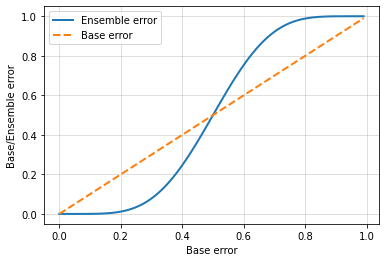

In [6]:
# 분류기 에러가 0.0에서 1.0까지 걸쳐있을 때 앙상블 에러율
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.0, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

# 앙상블과 개별 분류기 에러 사이의 관계를 선 그래프로 시각화
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

개별 분류기가 무작위 추축(에러율 < 0.5)보다 성능이 좋을 때 앙상블의 에러 확률이 개별 분류기보다 좋다.

# 7.2 다수결 투표를 사용한 분류 앙상블

### 7.2.1 간단한 다수결 투표 분류기 구현


In [7]:
np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6])

array([0.4, 0.6])

In [8]:
# argmax와 bincount 함수를 사용하여 가중치가 적용된 다수결 투표 구현
count = np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6])
print(count)
np.argmax(bin)

[0.4 0.6]


0

In [9]:
# average와 argmax 함수를 사용하여 클래스 확률 기반으로 가중치가 적용된 다수결 투표 구현
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [10]:
np.argmax(p)

0

In [11]:
# 다수결 투표 앙상블 분류기
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """
    매개변수
    - classifiers : list, 크기 = [n_classifiers], 앙상블에 사용할 분류기
    - vote : str, {'classlabel', 'probability'}, default='classlabel'
        'classlabel' 이면 예측은 다수인 클래스 레이블의 인덱스
        'probability' 이면 확률이 가장 큰 인덱스로 클래스 레이블 예측. - 보정된 분류기에 추천
    - weights : list, 크기 = [n_classifiers], 선택 사항
        default=None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치된다.
        'weights=None'이면 동일하게 취급합니다
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y): # 분류기 학습
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기와 가중치 개수는 같아야 합니다'
                             '; 가중치 %d 개, 분류기 %d 개'
                             % (len(self.weights), len(self.classifiers)))
        
        # self.predict 메서드에서 np.argmax를 호출할 때
        # 클래스 레이블이 0부터 시작되야 하므로 LabelEncoder 사용
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel' 투표
            # clf.predict 메서드를 사용하여 결과를 모은다
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """
        X에 대한 클래스 확률을 예측

        매개변수
        - X : {배열 타입, 회소 행렬}, 크기 = [n_samples, n_features]
              n_samples는 샘플의 개수, n_features는 특성의 개수인 샘플 데이터 행렬

        반환값
        - avg_proba : 배열 타입, 크기 = [n_samples, n_classes]
                      샘플마다 가중치가 적용된 클래스의 평균 확률
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        # GridSearch를 위해 분류기의 매개변수 이름을 반환
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out


### 7.2.2 다수결 투표 방식을 사용하여 예측 만들기


In [12]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

* 분류기
    * 로지스틱 회귀 분류기
    * 결정 트리 분류기
    * k-최근접 이웃 분류기

In [13]:
# 10-겹 교차 검증으로 성능 평가
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('[10-겹 교차 검증]')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

[10-겹 교차 검증]
ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


* 로지스틱 회귀와 k-최근접 이웃 분류기를 파이프라인으로 훈련시킨 이유
    * 로지스틱 회귀와 k-최근접 이웃 분류기는 결정 트리와 달리 **스케일에 민감**
    * 스케일에 민감하기 때문에 특성을 **표준화 전처리**를 해주어야 한다.

In [14]:
# 다수결 투표

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Major voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Major voting]


* 사이킷런의 `VotingClassifier` 클래스
    * estimators : 분류기 이름과 객체로 구성된 튜플의 리스트를 입력
    * voting
        * 'hard' : predict_proba 메서드 지원 X
        * 'soft' : ROC AUC를 계산하기 위한 predict_proba 메서드를 지원
    * verbose : True 지정 시, 진행 과정 출력.

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[
                        ('lr', pipe1), ('dt', clf2), ('knn', pipe3)], voting='soft')

scores = cross_validate(estimator=vc, X=X_train, y=y_train, cv=10, scoring='roc_auc')
print("ROC AUC: : %0.2f (+/- %0.2f) [%s]"
      % (scores['test_score'].mean(), 
         scores['test_score'].std(), 'VotingClassifier'))

ROC AUC: : 0.98 (+/- 0.05) [VotingClassifier]


In [16]:
vc.set_params(verbose=True)

vc = vc.fit(X_train, y_train)

[Voting] ....................... (1 of 3) Processing lr, total=   0.0s
[Voting] ....................... (2 of 3) Processing dt, total=   0.0s
[Voting] ...................... (3 of 3) Processing knn, total=   0.0s


voting='soft' 일 때 predict 메서드는 predict_proba 메서드에서 얻은 가장 큰 확률의 클래스를 예측으로 한다. predict_proba 메서드는 각 분류기의 클래스 확률을 평균하여 반환한다.

In [17]:
vc.predict_proba(X_test[:10])

array([[0.80858947, 0.19141053],
       [0.80798659, 0.19201341],
       [0.80742142, 0.19257858],
       [0.81176637, 0.18823363],
       [0.81195778, 0.18804222],
       [0.17701319, 0.82298681],
       [0.17670572, 0.82329428],
       [0.17845724, 0.82154276],
       [0.1796252 , 0.8203748 ],
       [0.81076201, 0.18923799]])

### 7.2.3 앙상블 분류기의 평과와 튜닝

* MajorityVoteClassifier의 일반화 성능을 확인하기 위해 테스트 데이터셋에 대한 ROC 곡선 시각화

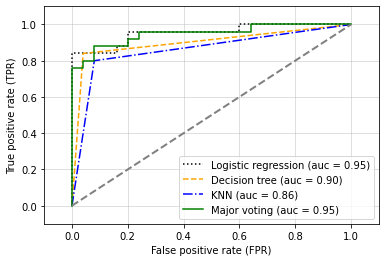

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # 양상 클래스의 레이블이 1이라고 가정.
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--',
         color='gray', linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

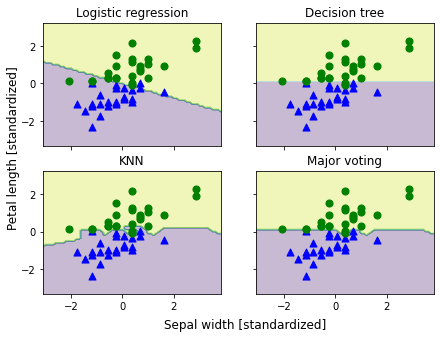

In [19]:
from itertools import product

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))


for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.show()

앙상블 분류기의 결정 경계는 개별 분류기의 결정 경계를 혼합한 것처럼 보인다. 처음 볼 때는 다수결 투표 결정 경계가 sepal width >= 1을 기준으로 y에 수직으로 그어진 결정 트리의 경계와 비슷해보인다. 또한 k-최근접 이웃 분류기의 비선형성이 섞여있는 것을 알 수 있다.

앙상블을 위해 개별 분류기의 매개변수를 튜닝하기 전에 GridSearchCV 객체 안에 있는 매개변수에 어떻게 접근할 수 있는지 get_params 메서드를 호출해서 알아본다.

In [20]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_int

get_params 메서드에서 반환되는 값을 살펴보면 개별 분류기의 속성에 접근하는 방법을 알 수 있다.

* GridSearchCV를 사용하여 로지스틱 회귀 분류의 규제 매개변수 C와 결정 트리의 깊이 튜닝

In [21]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth':[1, 2], 'pipeline-1__clf__C':[0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print('%0.3f +/- %0.2f %r' % (grid.cv_results_['mean_test_score'][r],
                                  grid.cv_results_['std_test_score'][r] / 2.0,
                                  grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [22]:
print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
정확도: 0.98


* 규제 강도(C) = 0.001 일 때 최상의 교차 검증 결과를 얻는다.
* 트리 깊이는 성능에 영향을 주지 않는 것처럼 보인다. 즉, 이 데이터를 분할하는 데은 깊이가 1인 결정 트리로 충분하다.

* `GridSearchCV`의 `refit` 기본값은 True이다. 훈련된 GridSearchCV 추정기를 사용해 `predict` 메서드로 예측을 만들 수 있다는 뜻이다.

        grid = GridSearchCV(estimator=mv_clf,
                            param_grid=params,
                            cv=10,
                            scoring='roc_auc')
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test)

또한 `best_estimator_` 속성으로 최상의 추정기를 얻을 수 있다.

In [23]:
grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [24]:
mv_clf = grid.best_estimator_
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ['clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1)]]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ['clf',
                                                     KNeighborsClassifier(n_neighbors=1)]])])

In [25]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

In [26]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

#### 스태킹을 사용한 앙상블
* 스태킹 알고리즘 : 두 개의 층을 가진 앙상블
    * 첫 번째 층의 개별 분류기 예측이 두 번째 층으로 주입된다
    * 두 번째 층에서 또 다른 분류기(전형적으로 로지스틱 회귀)가 최종 예측을 만들기 위해 첫 번째 층의 예측을 사용하여 학습된다.
* 사이킷런의 `StackingClassifier`, `StackingRegressor`
    * StackingClassifier
        * VotingClassifier와 비슷하게 estimators 매개변수로 분류기 이름과 객체로 구분된 튜플의 리스트를 입력받는다.
        * final_estimator 매개변수로는 최종 결정을 위한 분류기를 지정.
        * 매개변수 그리드를 지정할 때는 튜플에 사용한 분류기 이름을 접두사로 사용.

In [27]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators=[('lr', pipe1), ('dt', clf2), ('knn', pipe3)], 
                           final_estimator=LogisticRegression())

params = {'dt__max_depth': [1, 2],
          'lr__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=stack, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
        % (grid.cv_results_['mean_test_score'][r],
           grid.cv_results_['std_test_score'][r] / 2.0,
           grid.cv_results_['params'][r]))

0.950 +/- 0.07 {'dt__max_depth': 1, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 1, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 1, 'lr__clf__C': 100.0}
0.950 +/- 0.07 {'dt__max_depth': 2, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 2, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 2, 'lr__clf__C': 100.0}


In [28]:
print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'dt__max_depth': 1, 'lr__clf__C': 0.1}
정확도: 0.98
